# Binomial, Poisson and Gaussian distributions

Python notebook for illustrating the Binomial, Poisson and Gaussian distributions and how they in certain limits converge towards each other (and in the end into the Gaussian). The notebook also illustrates simple fitting.

## References:
- Barlow: Chapter 3
- Cowan: Chapter 2
- Particle Data Group: __["Probability theorem and distributions"](https://pdg.lbl.gov/2020/reviews/rpp2020-rev-probability.pdf)__

## Author(s), contact(s), and dates:
- Author: Troels C. Petersen (NBI)
- Email:  petersen@nbi.dk
- Date:   23rd of November 2022

***

In [231]:
import numpy as np                                     # Matlab like syntax for linear algebra and functions
import matplotlib as mpl
import matplotlib.pyplot as plt                        # Plots and figures like you know them from Matlab
from iminuit import Minuit                             # The actual fitting tool, better than scipy's
import sys                                             # Modules to see files and folders in directories

from scipy import stats
from scipy.stats import binom, poisson, norm   # Functions from SciPy Stats...
import scipy.special

Note that `SciPy Stats` has nearly every conceivable function implemented:
__["SciPy Stats functions"](https://docs.scipy.org/doc/scipy/reference/stats.html)__

In [232]:
sys.path.append('../../External_Functions')
from ExternalFunctions import Chi2Regression
from ExternalFunctions import nice_string_output, add_text_to_ax, add_header_to_ax   # Useful functions to print fit results on figure

We set up the parameters for the program:

In [233]:
# General settings:
r = np.random                       # Random generator
r.seed(42)                          # Fixed order of random numbers

save_plots = False
verbose = True
N_verbose = 10

# Set plotting parameters:
mpl.rcParams['font.size'] = 18      # Set the general plotting font size

# Plotting PDFs:

First, we want to have a look at the three PDFs (Binomial, Poisson, and Gaussian), and compare them given "the same" parameters. Of course we can't give the same input parameters, but at least we can require that they have the same mean and widths... Almost - one can not force the width of the Poisson to match that of the Binomial, once the mean is matched. The Gaussian will then have to choose between these two slightly different widths!

### Problem parameters:
* The Binomial PDF needs two parameters: Number of trials (n) and probability of succes (p).
* The Poisson PDF needs one parameter:  The expected number (lambda - but in Python we write it "Lambda" or "lamp", as "lambda" is reserved!).
* The Gaussian PDF needs two parameters: Mean (mu) and width (sigma).

In [234]:
def func_binomial_pmf(x, n, p):
    return binom.pmf(x, n, p)

In [235]:
def func_poisson_pmf(x, lamb):
    return poisson.pmf(x, lamb)

In [236]:
def func_gaussian_pdf(x, mu, sigma) :
    return norm.pdf(x, mu, sigma)

In [376]:
# Range of outcome:
xmin = -0.5
xmax = 500

# Function parameters:
# Binomial:
n = 10000
p = 1/60
# Poisson:
Lambda = n * p               # We choose this, as this is the expected number of successes.
# Gaussian:
mu = Lambda                  # Same here - the central value is n*p.
sigma = np.sqrt(n*p*(1-p))   # For a Binomial process, the variance is n*p*(1-p)
sigma = np.sqrt(n*p)         # Alternatively, one can use the Poisson width.
                             # Note how for small values of p, these expressions are essentially the same!!!

In [238]:
xaxis = np.linspace(xmin, xmax, 10000)
yaxis_binom = func_binomial_pmf(np.floor(xaxis+0.5), n, p)      # np.floor: See below
yaxis_poiss = func_poisson_pmf(np.floor(xaxis+0.5), Lambda)     # np.floor: See below
yaxis_gauss = func_gaussian_pdf(xaxis, n*p, np.sqrt(n*p*(1-p)))

# Note that the np.floor function takes the integer/rounded (towards zero) value of numbers.

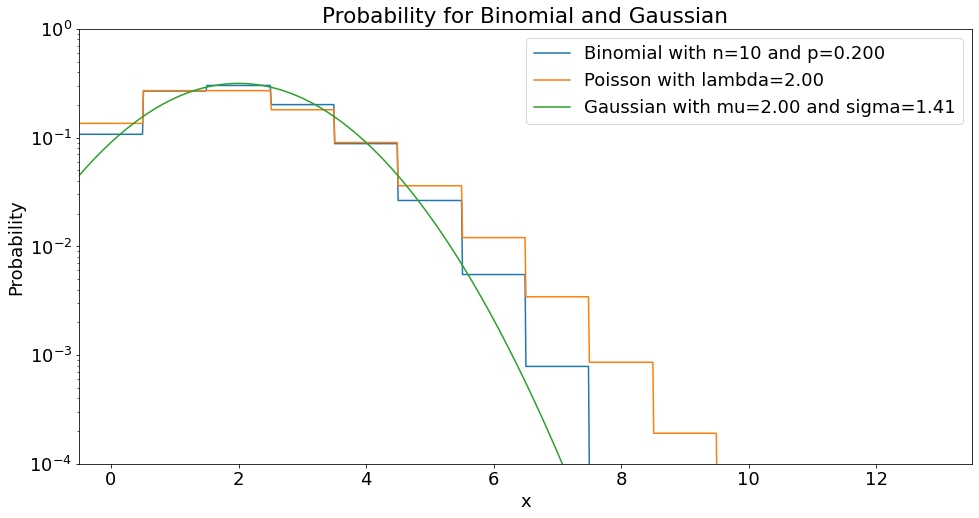

In [239]:
fig0, ax0 = plt.subplots(figsize=(16, 8))
ax0.plot(xaxis, yaxis_binom, '-', label=f'Binomial with n={n:2d} and p={p:.3f}')
ax0.plot(xaxis, yaxis_poiss, '-', label=f'Poisson with lambda={Lambda:.2f}')
ax0.plot(xaxis, yaxis_gauss, '-', label=f'Gaussian with mu={mu:.2f} and sigma={sigma:.2f}')
ax0.set(xlim=(xmin, xmax),
        title='Probability for Binomial and Gaussian', 
        xlabel='x', 
        ylabel='Probability')
ax0.set_yscale('log')
ax0.set_ylim(1e-4, 1.0)
ax0.legend(loc='upper right');

# Looping over processes:
In the following we simulate a Binomial/Poisson process with given parameters, i.e. number of trials and probability of success. For the Poisson, these can not be specified, but the resulting expected number is naturally lambda = n * p.

After having simulated the process, we fit the result with the three distributions in question, and test to what extend they match.

In [377]:
# Simulation parameters:
N_experiments = 1000              # Number of simulations/experiments to perform

N_trials = n                     # Number of trials in each experiment (taken from above!)
p_success = p                     # Chance of succes in each trial (taken from above!)
Lambda = N_trials * p_success     # This is the mean and the one parameter by which the Poisson is defined!

print(f"  With N_trials = {N_trials:d} and p_success = {p_success:.4f}, the average number of successes is lambda = {Lambda:.2f}")

  With N_trials = 10000 and p_success = 0.0167, the average number of successes is lambda = 166.67


In [378]:
all_n_success = np.zeros(N_experiments)

# Run the experiments, and fill the histogram from above:
for iexp in range(N_experiments): 
    
    # Simulating process defined:
    n_success = 0
    for i in range(N_trials): 
        x = r.uniform()
        if (x < p_success): 
            n_success += 1

    # Record result:
    # if (verbose and iexp < N_verbose): 
    #     print(f"n_success: {n_success:4d}")
        
    # Save Result
    all_n_success[iexp] = n_success

## Plot result:

Define a histogram with the "data" (note and think about the binning!). Also, ask yourself what uncertainty to assign to each bin?<br>
The line of thinking should be: "There are many possibilities of ending up in a specific bin, but the probability of doing so is each low".

In [379]:
counts, bin_edges = np.histogram(all_n_success, bins=N_trials+1, range=(-0.5, N_trials+0.5))
bin_centers = (bin_edges[1:] + bin_edges[:-1])/2
s_counts = np.sqrt(counts)                         # NOTE: We (naturally) assume that the bin count is Poisson distributed.

In [380]:
# We remove any bins, which don't have any counts in them (for Chi2 fitting):
x = bin_centers[counts>0]
y = counts[counts>0]
sy = s_counts[counts>0]

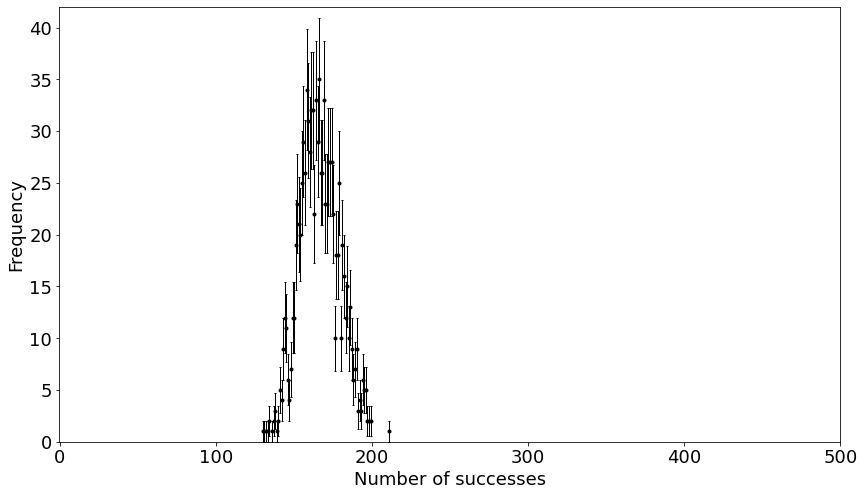

In [381]:
fig, ax = plt.subplots(figsize=(14, 8))
ax.errorbar(x, y, yerr=sy, xerr=0.5, label='Distribution of nSuccesses', fmt='.k',  ecolor='k', elinewidth=1, capsize=1, capthick=1)
ax.set(xlim=(xmin, xmax), ylim=(0, 1.2*np.max(y)), xlabel='Number of successes', ylabel='Frequency');

In [245]:
print(0.2**11 * 0.8**9 * np.math.factorial(20) / (np.math.factorial(11) * np.math.factorial(9))*1000)

0.46168493250314285


## Fitting with a Binomial:

First define the (fitting) function:

In [246]:
def func_binomial(x, N, n, p):
    return N * binom.pmf(x, n, p)

Then fit it with a $\chi^2$-fit:

In [382]:
Minuit.print_level = 1

chi2_bin = Chi2Regression(func_binomial, x, y, sy)
chi2_bin.errordef = 1
minuit_bin = Minuit(chi2_bin, N=N_experiments, n=N_trials, p=p_success) #   
minuit_bin.migrad()
Chi2_bin = minuit_bin.fval
Ndof_bin = len(x) - 3        # 3 parameters in fit
Prob_bin = stats.chi2.sf(Chi2_bin, Ndof_bin)# Perform the actual fit


And plot it on the figure:

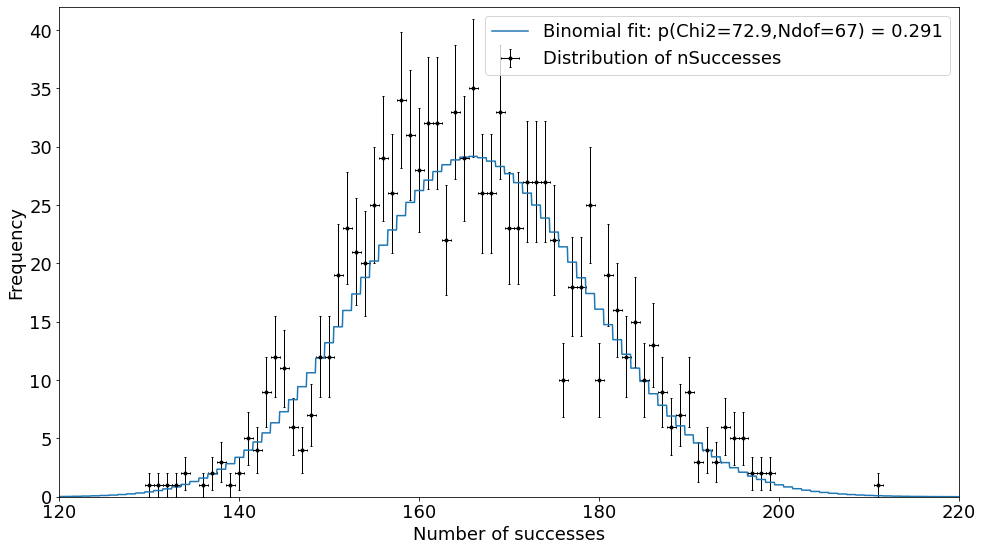

In [393]:


fig, ax = plt.subplots(figsize=(14, 8), facecolor = "white")

xaxis = np.linspace(xmin, xmax, 10000)

ax.errorbar(x, y, yerr=sy, xerr=0.5, label='Distribution of nSuccesses', fmt='.k',  ecolor='k', elinewidth=1, capsize=1, capthick=1)
ax.set(xlim=(120, 220), ylim=(0, 1.2*np.max(y)), xlabel='Number of successes', ylabel='Frequency');

xaxis = np.linspace(-0.5, xmax+0.5, 10000)                  # This way we include all possibilties!
yaxis = func_binomial(np.floor(xaxis+0.5), *minuit_bin.values[:])
ax.plot(xaxis, yaxis, '-', label=f'Binomial fit: p(Chi2={Chi2_bin:.1f},Ndof={Ndof_bin:d}) = {Prob_bin:.3f}')
ax.legend()
fig.tight_layout()

## Fitting with a Poisson:

In [249]:
def func_poisson(x, N, mu) :
    return N * poisson.pmf(x, mu)

In [389]:
chi2_poisson = Chi2Regression(func_poisson, x, y, sy)
chi2_poisson.errordef = 1
minuit_poisson = Minuit(chi2_poisson, N=N_experiments, mu=Lambda) #   
minuit_poisson.migrad();           # Perform the actual fit (without printing)
Chi2_poi = minuit_poisson.fval
Ndof_poi = len(x) - 2              # 2 parameters in fit
Prob_poi = stats.chi2.sf(Chi2_poi, Ndof_poi)

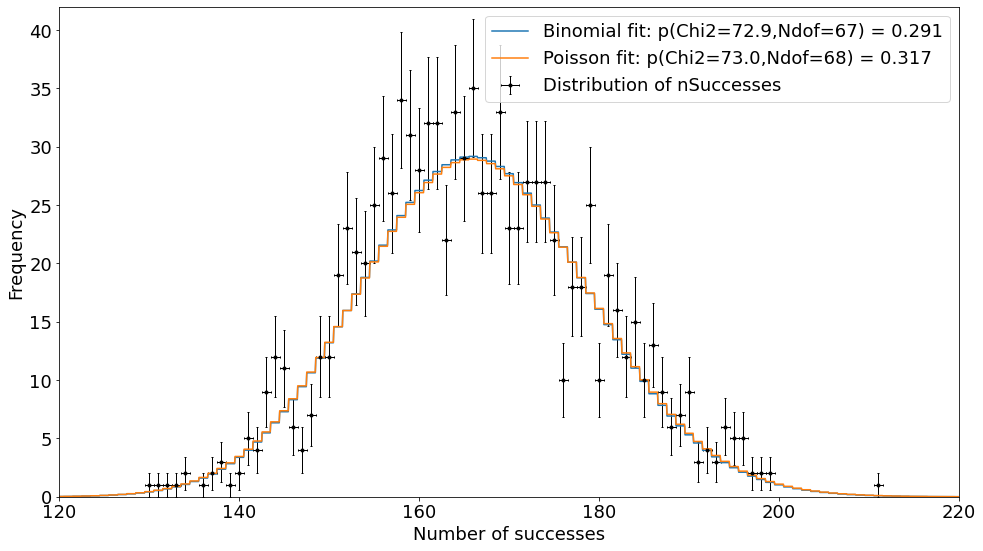

In [394]:
yaxis = func_poisson(np.floor(xaxis+0.5), *minuit_poisson.values[:])
ax.plot(xaxis, yaxis, '-', label=f'Poisson fit: p(Chi2={Chi2_poi:.1f},Ndof={Ndof_poi:d}) = {Prob_poi:.3f}')
ax.legend()
fig.tight_layout()
fig

## Fitting with a Gaussian:

In [252]:
def func_gaussian(x, N, mu, sigma) :
    return N * norm.pdf(x, mu, sigma)

In [390]:
chi2_gaussian = Chi2Regression(func_gaussian, x, y, sy)
chi2_gaussian.errordef = 1
minuit_gaussian = Minuit(chi2_gaussian, N=N_experiments, mu=Lambda, sigma=np.sqrt(Lambda)) #   
minuit_gaussian.migrad();       # Perform the actual fit
Chi2_gau = minuit_gaussian.fval
Ndof_gau = len(x) - 3           # 3 parameters in fit
Prob_gau = stats.chi2.sf(Chi2_gau, Ndof_gau)

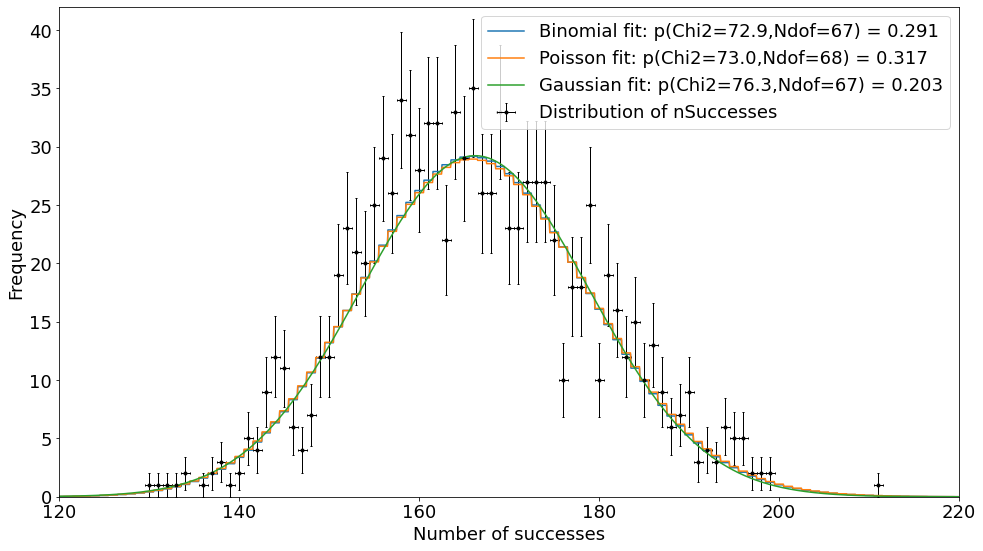

In [395]:
yaxis = func_gaussian(xaxis, *minuit_gaussian.values[:])
ax.plot(xaxis, yaxis, '-', label=f'Gaussian fit: p(Chi2={Chi2_gau:.1f},Ndof={Ndof_gau:d}) = {Prob_gau:.3f}')
ax.legend()
fig.tight_layout()
fig

And save the figure:

In [255]:
if save_plots: 
    fig.savefig("BinomialPoissonGaussian.pdf")

5.0 31.0
0.6556814685290175 0.10165024832681843
gauss Chi2 and Ndof 33.11596179709542 24
binom Chi2 and Ndof 20.71148592394036 24


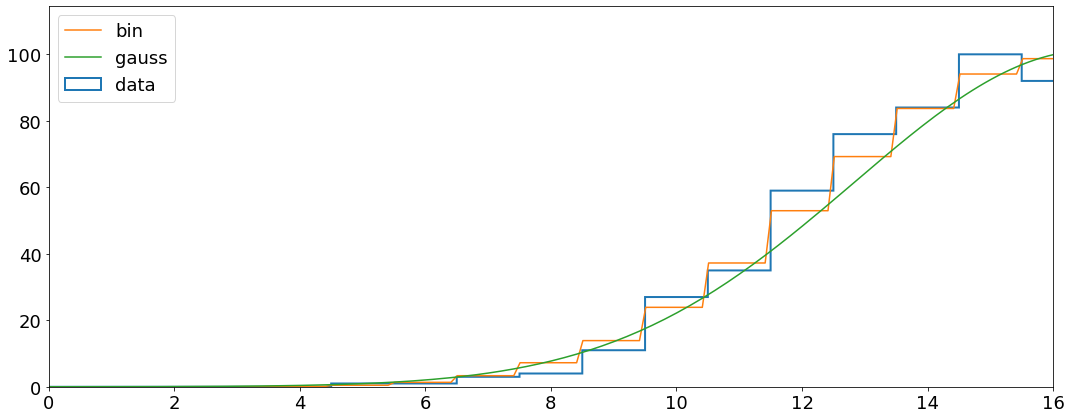

In [360]:
# Simulation parameters:
N_experiments = 1000              # Number of simulations/experiments to perform

N_trials = 1000                      # Number of trials in each experiment (taken from above!)
p_success = 1/60                     # Chance of succes in each trial (taken from above!)
Lambda = N_trials * p_success     # This is the mean and the one parameter by which the Poisson is defined!

N_runs = 100

plot = True

pvalues = np.zeros((4, N_runs))
# print(pvalues)
for run in range(N_runs):
    all_n_success = np.zeros(N_experiments)

    # Run the experiments, and fill the histogram from above:
    for iexp in range(N_experiments): 
        
        # Simulating process defined:
        n_success = 0
        for i in range(N_trials): 
            x = r.uniform()
            if (x < p_success): 
                n_success += 1

        # Record result:
        # if (verbose and iexp < N_verbose): 
        #     print(f"n_success: {n_success:4d}")
            
        # Save Result
        all_n_success[iexp] = n_success
    # all_n_success = all_n_succ[(data > np.percentile(data, tp_range[0])) & (data < np.percentile(data, tp_range[1]))]
    
    counts, bin_edges = np.histogram(all_n_success, bins=N_trials+1, range=(-0.5, N_trials+0.5))
    
    bin_centers = (bin_edges[1:] + bin_edges[:-1])/2
    s_counts = np.sqrt(counts)

    x = bin_centers[counts>0]
    y = counts[counts>0]
    sy = s_counts[counts>0]

    #binomial fit
    Minuit.print_level = 1

    chi2_bin = Chi2Regression(func_binomial, x, y, sy)
    chi2_bin.errordef = 1
    minuit_bin = Minuit(chi2_bin, N=N_experiments, n=N_trials, p=p_success) #   
    minuit_bin.migrad() 
    Chi2_bin = minuit_bin.fval
    Ndof_bin = len(x) - 3        # 3 parameters in fit
    Prob_bin = stats.chi2.sf(Chi2_bin, Ndof_bin)

    #poisson fit
    chi2_poisson = Chi2Regression(func_poisson, x, y, sy)
    chi2_poisson.errordef = 1
    minuit_poisson = Minuit(chi2_poisson, N=N_experiments, mu=Lambda) #   
    minuit_poisson.migrad();           # Perform the actual fit (without printing)
    Chi2_poi = minuit_poisson.fval
    Ndof_poi = len(x) - 2              # 2 parameters in fit
    Prob_poi = stats.chi2.sf(Chi2_poi, Ndof_poi)

    #gauss fit
    chi2_gaussian = Chi2Regression(func_gaussian, x, y, sy)
    chi2_gaussian.errordef = 1
    minuit_gaussian = Minuit(chi2_gaussian, N=N_experiments, mu=Lambda, sigma=np.sqrt(Lambda*(1-p_success))) #   
    minuit_gaussian.migrad();       # Perform the actual fit
    Chi2_gau = minuit_gaussian.fval
    Ndof_gau = len(x) - 3           # 3 parameters in fit
    Prob_gau = stats.chi2.sf(Chi2_gau, Ndof_gau)


    N_bins = len(x)                # Just to know how many bins to loop over
    chi2_bino = 0.0                # This you'll add to
    N_dof = len(x) 
    for N_obs, x_i in zip(y, x):
        N_exp = func_binomial(x_i, N_experiments, N_trials, p_success)
        # print(N_exp)
        if (N_obs > 0) :
            chi2_bino += (N_obs - N_exp)**2 / N_exp       # Write the expression yourself!

    # Also calculate Ndof and Prob:
    Ndof_bino_our = N_dof               # Think about/write the number of degrees of freedom given no free parameters!
    Prob_bino_our = stats.chi2.sf(chi2_bino, Ndof_bino_our)

    pvalues[:, run] = [Prob_bin, Prob_poi, Prob_gau, Prob_bino_our]
    
    if (Prob_bin > (Prob_gau + 0.5)) & plot:
        
        plot = False
        plt.figure(figsize = (18,7))
        plt.hist(all_n_success, bins = N_trials+1, range=(-0.5, N_trials+0.5), histtype = "step", linewidth = 2, label = "data")
        xaxis = np.linspace(-0.5, N_trials+0.5, 10000)  
        yaxis = func_binomial(np.floor(xaxis+0.5), *minuit_bin.values[:])
        plt.plot(xaxis, yaxis, "-", label = "bin")
        yaxis = func_gaussian(xaxis, *minuit_gaussian.values[:])
        plt.plot(xaxis, yaxis, label = "gauss")
        plt.xlim(0, 16)
        plt.legend()
        print(min(all_n_success), max(all_n_success))
        print(Prob_bin, Prob_gau)
        
        print("gauss Chi2 and Ndof", Chi2_gau, Ndof_gau)
        print("binom Chi2 and Ndof", Chi2_bin, Ndof_bin)
        
        
plt.show()  
# print(pvalues)

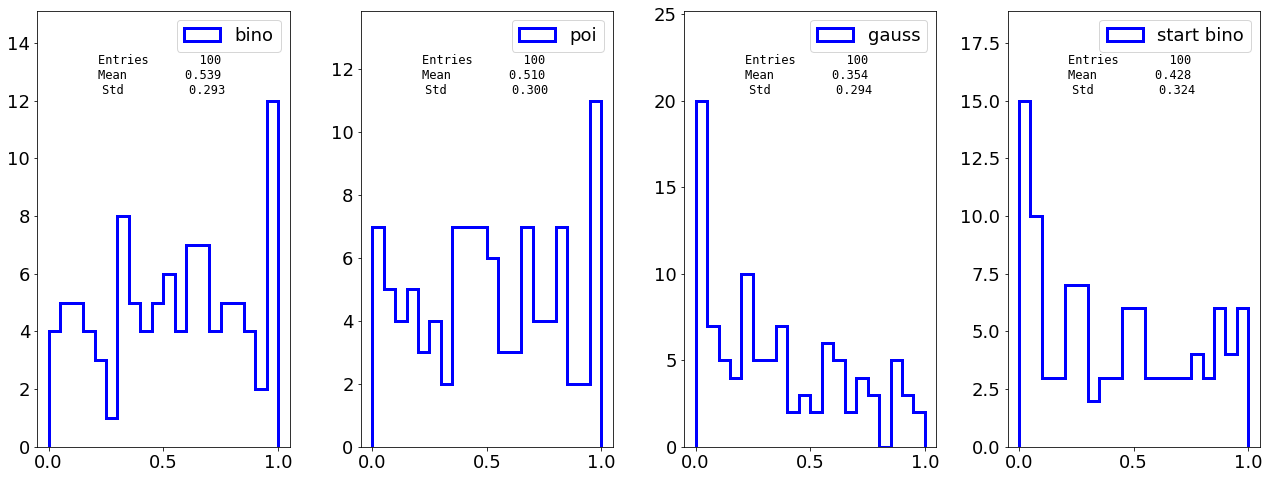

In [361]:
fig, axes = plt.subplots(1, 4, figsize = (18,7), facecolor = "white")

labels = ["bino", "poi", "gauss", "start bino"]
for dist, label, ax in zip(range(4), labels, axes):
    ax.hist(pvalues[dist], bins = 20, range = (0, 1), label = label, histtype = "step", linewidth = 3, color = "b")
    add_header_to_ax(pvalues[dist], 0.5, 0.9, ax, halignment="center")
    ymax = ax.get_ylim()[1]*1.2
    ax.set_ylim(0, ymax)
    ax.legend()

fig.tight_layout()
plt.show()
    


## Calculation of Binomial $\chi^2$-value:

In this part of the exercise, you are asked to calculate the ChiSquare value yourself, in order to ensure that you understand exactly what is going on!

Above, we have (using Minuit) *fitted* the distribution, but as we know the initial values, I would like you to calculate the $\chi^2$-value between the data and the binomial they were generated from, i.e. with NO free parameters.

I suggest you use Pearson's $\chi^2$, and require `N_obs` and/or `N_exp` > e.g. 0.1. Remember that your choice should ensure, that there is no division by zero (which is a cardinal sin in programming)!

In [256]:
N_bins = len(x)                # Just to know how many bins to loop over
chi2_bino = 0.0                # This you'll add to
N_dof = 0                      

In [257]:
print(y)
print(x)

[ 87 250 334 223  78  24   4]
[0. 1. 2. 3. 4. 5. 6.]


In [258]:
N_bins = len(x)                # Just to know how many bins to loop over
chi2_bino = 0.0                # This you'll add to
N_dof = 0 

for N_obs, x_i in zip(y, x):
    N_exp = func_binomial(x_i, N_experiments, N_trials, p_success)
    print(N_exp)
    if (N_obs > 0) :
        chi2_bino += (N_obs - N_exp)**2 / N_exp       # Write the expression yourself!

# Also calculate Ndof and Prob:
Ndof_bino = N_bins                # Think about/write the number of degrees of freedom given no free parameters!
Prob_bino = stats.chi2.sf(chi2_bino, Ndof_bino)

107.37418240000007
268.435456
301.98988800000006
201.32659199999992
88.0803839999999
26.424115199999985
5.505024000000005


In [259]:


print(f"Just a test printout, change to match your own results! \n")
print(f"Binomial:   chi2 = {chi2_bino:.2f}   N_dof = {Ndof_bino:d}   Prob = {Prob_bino:6.4f}")

Just a test printout, change to match your own results! 

Binomial:   chi2 = 12.65   N_dof = 7   Prob = 0.0812


In [260]:
print(20 * 0.2 * 0.8)
print(x)

3.2
[0. 1. 2. 3. 4. 5. 6.]


1.8973665961010275 2.8284271247461903


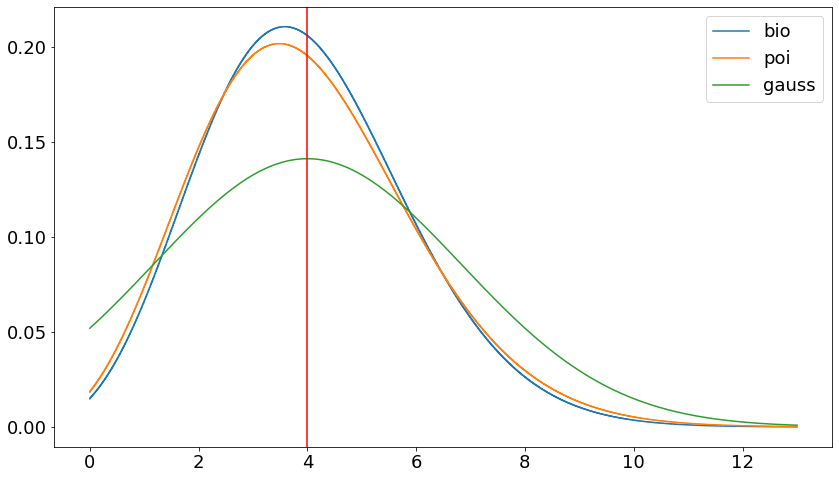

In [261]:
xlin = np.linspace(0, 13, 14)
x_gau = np.linspace(0, 13, 1000)

def con_bio(x, n, p):
    return p**x * (1 - p)**(n - x) * scipy.special.binom(n,x)

def con_poi(x, lamb):
    return np.exp(-lamb) * lamb**x / scipy.special.factorial(x)

n = 40
p = 0.1
l = n * p

y_con_bio = con_bio(x_gau, n, p)
y_con_poi = con_poi(x_gau, l)

y_bio = func_binomial_pmf(xlin, 16, 0.5)
y_poi = func_poisson_pmf(xlin, 8)
y_gau = func_gaussian_pdf(x_gau, n*p, np.sqrt(8))

print(np.sqrt(n * p * (1-p)), np.sqrt(8))

fig, ax = plt.subplots(figsize = (12, 7), facecolor = "white")
ax.step(x_gau, y_con_bio, label = "bio")
ax.step(x_gau, y_con_poi, label = "poi")
ax.plot(x_gau, y_gau, label = "gauss")

ax.axvline(4, color = "red")
 
ax.legend()
fig.tight_layout()
plt.show()

***


# Questions:

Important: Make sure you understand what process yields a Binomial, a Poisson and a Gaussian distribution. Without this knowledge, this exercise and a large fraction of the course will be lost on you!

1. Plot a Binomial ($N=20$, $p=0.2$), Poisson ($\lambda = 4$), and Gaussian ($\mu=4$, $\sigma=\sqrt{4}$), i.e. same means and widths. Which distribution has the longest tail towards high values? 

poission ditrubtion gets the longest tail. gaussian ofcause has no tail and for small n bional also has a small tail in the high values. Poissions tail only disappears at low p values. 

And which one has the longest tail the other way? 

Gaussian is symmetrical, and they other distrbutions are limited to positive values, so gaussian will always have a larger tail towards low values.

Does this pattern depend on the parameters (given same means and widths)?

A poission with a lambda less than 0.19 then it will have a higher probability in the tail less than the mean compared to a gaussian with same width and mean. Any higher value of lambda results in a bigger tail for the gaussian. 



 Play around with the settings (remember also to change the scale (use log) of the plot accordingly), and gain your own experience. And most importantly perhaps, in what limits do they start looking like each other?

 for binomial goes to gaussian as n becomes large. binominal goes to poisson as np(1-p) is similar to np ($\lambda$). poisson goes to gaussian as $\lambda$ goes becomes large. 

2. Producing binomially distributed numbers (using the parameters `N_experiments=1000`, `N_trials=10` and `p_success=0.2`), do $\chi^2$ fits of the resulting distribution with a Binomial, a Poisson, and a Gaussian distribution. Do you get acceptable fit probabilities with all of these? If not, investigate for what choice of parameters you do.

For these parameters the first time we get p(bio) = 0.532, p(poi) = 0.000 and p(gau) = 0.232. If running multiple times the experiments we find that binonal is on average p = 0.5. This is to be expected. One would expect gaussian fits to becomes better for high N_trials, as that is the limit for which binominal becomes gaussian, but we find this is not the case. It could be that gaussian fit is more sensitive to outliers, but we could not conclude the reason for this. The effect is shown well at low p. Here Bino and Poisson is in great agreement in general, but gaussian has a lot of fits with high Chi2 value.  

3. Calculate the $\chi^2$ between the data and the original Binomial distribution (which the data is generated from). Since you are not fitting anything, what is the number of degrees of freedom? Does it give a reasonable $\chi^2$-probability?

The number of degrees of freedom is equal to the number of datapoints as we do not fit to any parameters, just use the knowledge of the distribution. We on average get a good p value.

4. In all of the above $\chi^2$ fits, we have _assumed_ that the uncertainty on the count in each bin is Gaussianly distributed! Ask yourself to what extend this requirement is fulfilled? Does changing the parameters (`N_experiments`, `N_trials` and `p_success`) "help" fulfilling this requirement, and if so, which and how?

So the error on a given bin should theoredically be $\sigma_{j} = \sqrt{NW_{j}p(x_{j},a)}$ this is different from the plotted error which is $\sigma_{j} = \sqrt{n_{j}}$. As N_experiments increases the obtained data will tend towards the starting distibution and the errors will be approximately the same. Therefore the errors are only gaussian at large N_experiments. But large N_experiments are not the only concern. For the same N_experiments the approximation is also dependant on the width of the theoretical distibution. So the point is that the errors are only approximately gaussian for "high"/good statistics (e.g. good sampling of the entire distribution).

### Advanced questions:

5. Using `N_experiments=1000`, `N_trials=1000` and `p_success=1/60`, is the skewness consistent with zero (as the Gaussian should have)?

skewness is present, with such low p value. If N_trails is increased even more, the skewness decreases. 

# Learning points:

Generally, you should understand the concept of a PDF, and that there are many such, though in this course we only consider 10 or so. Some are *continuous* (e.g. exponential and Gaussian) and some are *discrete* (e.g. Binomial and Poisson).

In this exercise, you should have learned:
1. What the conditions leading to a Binomial and a Poisson distribution are.
2. In what limit of $N_{trials}$ and $p_{succes}$ the Binomial converges towards the Poisson.
3. That in the limit of $N_{trials} \times p_{succes} \to \infty$ and $\lambda \to \infty$, the two distributions become Gaussian (though discrete).
4. **That the uncertainty on a Poisson number is the square root of that number**.

One consequence of 4), is that we choose number of counts in a bin $N$ to have $\sqrt{N}$ as uncertainty. It should be noted, that for low $N$, the uncertainty is not very Gaussian.

You should also have learned how to choose binning when making a histogram of integers. 